# Duplicate Bot Tweets

Import our libraries needed for the data handling.

In [1]:
import pandas as pd
import numpy as np
import json
import glob

In [2]:
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)
# and increase the max number of rows we can show
pd.set_option('display.max_rows', 100)

Libraries for stupid text encoding

In [3]:
from urllib2 import quote
# Unicode strings
from __future__ import unicode_literals

Import libraries needed for visualization.

In [104]:
import matplotlib
import matplotlib.pyplot as plt
# Within notebook viewing
%matplotlib inline
import seaborn as sns

print (matplotlib.__version__)

1.5.3


In [5]:
# Import for axes, color, etc
from pylab import *

Natural Language Processing

In [6]:
%run twokenize.py
import nltk

In [7]:
# time deltas
from datetime import timedelta

### Directories

In [8]:
testDir = '../../data/external/trump-bots/'
botDir = '../../data/external/botresults/'
outDir = '../../data/processed/bot-tweets/'

Read in the data files by combining the extracted files.

In [9]:
# Crudely combine
process = []
for f in glob.glob((botDir + "*.txt")):
    with open(f, "rb") as infile:
        for line in infile:
            process.append(json.loads(line))
raw = pd.DataFrame.from_records(process)

del process

print (raw.shape)

(77722, 33)


##### Helper functions

In [10]:
def tknz(text):
    tokens = tokenizeRawTweetText(text)
    filt = [x for x in tokens if not (x.startswith('RT') 
                                   or x.startswith('@') or x.startswith(':') 
                                   or x.startswith('http://') or x.startswith('https://') 
                                  or x.startswith('-') or x.startswith('and') 
                                    or x.startswith('.') or x.startswith(',') 
                                     or x.startswith("'") or x == ('' or '"' or 'a'))]
    return filt

def hsh(tokens):
    # reads a list of tokens
    # tuped = tuple(tokens)
    tuped = ', '.join(tokens)
    hashed = hash(tuped)
    return hashed

In [11]:
def extractInfo(tweet):
    # User variables
    userID = tweet['user']['id_str']
    screenName = tweet['user']['screen_name']
    # Tweet Variables
    text = tweet['text']
    tokens = tknz(text)
    hashed = hsh(tokens)
    retweet = 1 if (type(tweet['retweeted_status']) == dict) else 0
    retweet_count = tweet['retweet_count']
    favorite_count = tweet['favorite_count']
    
    timestamp = tweet['timestamp_ms']
    
    return {'userID':userID, 'screenName':screenName, 'timestamp':timestamp, \
            'text':text, 'tokens':tokens, 'hash':hashed, 'retweet':retweet,
           'retweet_count': retweet_count, 'favorite_count':favorite_count}
    
    #### below is a horrible rendition of network variables
    
"""
# RT, reply, quoting, or none?
    try:
        if (tweet['retweeted_status'] == True):
            method = 'retweet'
            otherID = tweet['retweeted_status']['user']['id_str']

        if (type(tweet['in_reply_to_user_id_str']) != np.float64):
            method = 'replyUser'
            otherID = tweet['in_reply_to_user_id_str']
        elif (tweet['in_reply_to_status_id_str']):
            method = 'replyStatus'
            otherID = None
        else:
            method = None
            otherID = None

        return {'userID':userID, 'screenName':screenName, 'text':text, 'timestamp':timestamp,
                'method':method, 'otherID':otherID}
    except:
        print tweet
"""

u"\n# RT, reply, quoting, or none?\n    try:\n        if (tweet['retweeted_status'] == True):\n            method = 'retweet'\n            otherID = tweet['retweeted_status']['user']['id_str']\n\n        if (type(tweet['in_reply_to_user_id_str']) != np.float64):\n            method = 'replyUser'\n            otherID = tweet['in_reply_to_user_id_str']\n        elif (tweet['in_reply_to_status_id_str']):\n            method = 'replyStatus'\n            otherID = None\n        else:\n            method = None\n            otherID = None\n\n        return {'userID':userID, 'screenName':screenName, 'text':text, 'timestamp':timestamp,\n                'method':method, 'otherID':otherID}\n    except:\n        print tweet\n"

In [12]:
extracted = pd.DataFrame.from_records(raw.apply(lambda x: extractInfo(x), axis=1))

# throw out the tweets we can't classify
extracted = extracted[extracted['hash'] != 0]

# Calc variables
extracted['timestamp'] = pd.to_datetime(extracted['timestamp'], unit='ms')
extracted['token_str'] = extracted['tokens'].apply(lambda x: ', '.join(x))

extracted.head()

,favorite_count,hash,retweet,retweet_count,screenName,text,timestamp,tokens,userID,token_str
0,0,8401775961062800512,1,0,Scrufey21,RT @robinleeclark: Hillary is a murderer and a...,2015-07-06 00:12:43.046,"[Hillary, is, a, murderer, a, traitor, that's,...",490179072,"Hillary, is, a, murderer, a, traitor, that's, ..."
1,0,-7017692310915600254,1,0,Scrufey21,RT @PatriotMash: Clinton uses two aides and a ...,2015-07-06 00:17:23.293,"[Clinton, uses, two, aides, a, rope, to, lasso...",490179072,"Clinton, uses, two, aides, a, rope, to, lasso,..."
2,0,4819910249842125834,1,0,Scrufey21,RT @NoahWehrman: Press prepare for another day...,2015-07-06 00:19:58.259,"[Press, prepare, for, another, day, of, coveri...",490179072,"Press, prepare, for, another, day, of, coverin..."
3,0,8041086589735528761,0,0,CyberAnonymous,nytimes: Hillary Clinton reassures gay youth i...,2015-07-06 00:20:15.542,"[nytimes, Hillary, Clinton, reassures, gay, yo...",128334973,"nytimes, Hillary, Clinton, reassures, gay, you..."
4,0,-4371809372265221000,1,0,Scrufey21,RT @LessGovMoreFun: Truth be told: https://t....,2015-07-06 00:20:17.984,"[Truth, be, told]",490179072,"Truth, be, told"


In [81]:
# users
userAgg = {
    'userID': {
        'count': 'count'
    }, 'timestamp': {
        'first_day': 'min',
        'last_day': 'max',
        # Calculate time delta # # ).days if (max(x)-min(x).hours > 24) else (max(x)-min(x)).hours
        'time_delta': lambda x: max(x)-min(x)
    }, 
    'favorite_count': {
        'total_favorites': 'sum',
        'avg_favorites': 'mean'
    },
    'retweet_count': {
        'total_retweets': 'sum',
        'avg_retweets': 'mean'
    }
}

aggBots = extracted.groupby(['screenName']).agg(userAgg)

In [88]:
aggBots.head(1)

timestamp                           \
                         first_day               time_delta   
screenName                                                    
140GeV     2015-08-01 22:39:42.386 428 days 04:53:29.097000   

                                   retweet_count                userID  \
                          last_day  avg_retweets total_retweets  count   
screenName                                                               
140GeV     2016-10-03 03:33:11.483             0              0     13   

            favorite_count                
           total_favorites avg_favorites  
screenName                                
140GeV                   0             0

In [90]:
# reset the index so it's easier to work with
#aggBots.reset_index(col_level=1, inplace=True, drop=False)
aggBots.columns = ['screenName', 'first_day', 'time_delta', 'last_day', 'avg_retweets', 'total_retweets', 'count',\
                      'total_favorites', 'avg_favorites']  

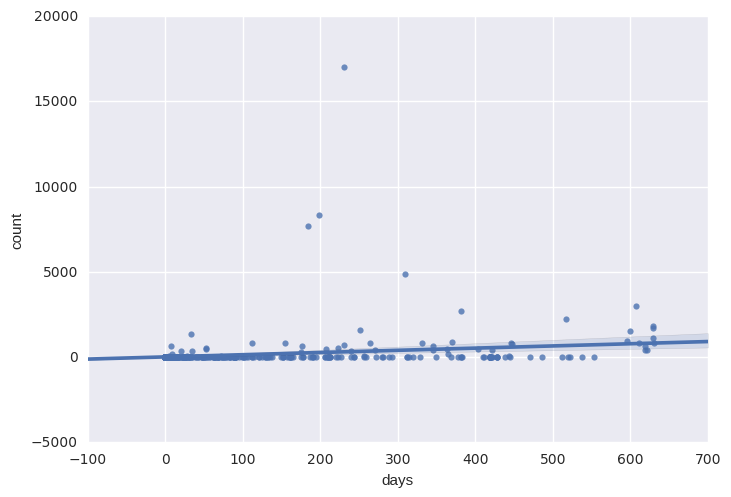

In [116]:
sns.regplot(x="days", y="count", data=aggBots);

In [131]:
aggBots['time_delta'].apply(lambda x: x.days).median()

0.0

In [115]:
#aggBots.timestamp.time_delta.apply(lambda x: x.days()).hist()

aggBots[['screenName', 'time_delta', 'count']]\
    .sort_values('time_delta', ascending=False)\
    .head(100).style.format(timeDeltaDisplay, subset=['time_delta'])\
    .bar(subset=['count', 'total_favorites', 'total_retweets', 'time_delta', 'uniq_users'], color='#d65f5f')


In [101]:
aggBots['days'] = aggBots['time_delta'].apply(lambda x: x.days)

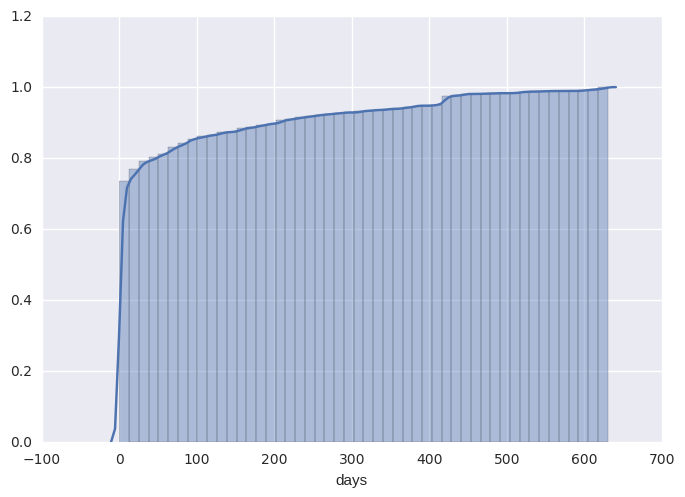

In [105]:
sns.distplot(aggBots.days,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

In [13]:
# Get most popular 
print ('Most popular tweet hashes.')

popularTweets = extracted['hash'].value_counts()
popularTweets.columns = ['frequency']
print (popularTweets.head(10))

Most popular tweet hashes.
-535364539560055252     1574
-1290198111922655402    1362
 1650226427655343970     807
-5630792624845697664     624
-4102906781732687656     520
 5602520607808939820     484
 3167448423410501280     176
 8100076757054270788     146
-7094954994022569809     142
-324005199201011350      123
Name: hash, dtype: int64


In [59]:
# do the same to lookup tokens
popularTokens = extracted['token_str'].value_counts()
print ('Most popular tokens')
popularTokens.head(25)

Most popular tokens


Donald, Trump, was, just, mentioned, during, Erin, Burnett, OutFront, on, CNNHD, read, more                     1574
Dear, #MicroAggression, jump, on, the, #TrumpTrain                                                              1362
#RealDonaldTrump, will, save, us                                                                                 807
Donald, Trump, was, just, mentioned, on, FNCHD, #donaldtrump, #trump2016, read, more                             624
Donald, Trump, was, just, mentioned, on, MSNBC, #donaldtrump, #trump2016, read, more                             520
Donald, Trump, was, just, mentioned, on, CNNHD, #donaldtrump, #trump2016, read, more                             484
Donald, Trump, was, just, mentioned, during, The, O'Reilly, Factor, on, FNCHD, read, more                        176
Check, out, Donald, Trump, Your, President, #Trump2016, #TrumpTrain, by, Rick, Poppe                             146
Donald, Trump, was, just, mentioned, during, America's, News, He

### Most Popular Tweets without @donaldtrumptvfan

In [60]:
#popularTokens.iloc[:99].index[0][:25]
# # >u'Donald, Trump, was, just,'
filteredPopularTokens = popularTokens.iloc[:99][popularTokens.iloc[:99].index.str[:25] != 'Donald, Trump, was, just,' or '']
print (filteredPopularTokens.size)
filteredPopularTokens

44


Dear, #MicroAggression, jump, on, the, #TrumpTrain                                                                                         1362
#RealDonaldTrump, will, save, us                                                                                                            807
Check, out, Donald, Trump, Your, President, #Trump2016, #TrumpTrain, by, Rick, Poppe                                                        146
What, can, we, do, to, make, America                                                                                                        123
#Clinton, Hillary, Clinton, releases, Web, ad, slamming, Donald, Trump, over, taxes                                                         103
Have, you, heard, Donald, Trump, Your, President, by, rickpoppe, on, #SoundCloud, ?, #TrumpTrain, #Trump2016                                 99
#Clinton, Hillary, Clinton, Why, Employers, Should, Give, Ex-Offenders, A, Second, Chance                                               

In [16]:
# start a data frame for each conceptual tweet
hashes = extracted[['tokens', 'token_str', 'hash']].set_index('hash')

hashes.head()

,tokens,token_str
hash,,
8401775961062800512,"[Hillary, is, a, murderer, a, traitor, that's,...","Hillary, is, a, murderer, a, traitor, that's, ..."
-7017692310915600254,"[Clinton, uses, two, aides, a, rope, to, lasso...","Clinton, uses, two, aides, a, rope, to, lasso,..."
4819910249842125834,"[Press, prepare, for, another, day, of, coveri...","Press, prepare, for, another, day, of, coverin..."
8041086589735528761,"[nytimes, Hillary, Clinton, reassures, gay, yo...","nytimes, Hillary, Clinton, reassures, gay, you..."
-4371809372265221000,"[Truth, be, told]","Truth, be, told"


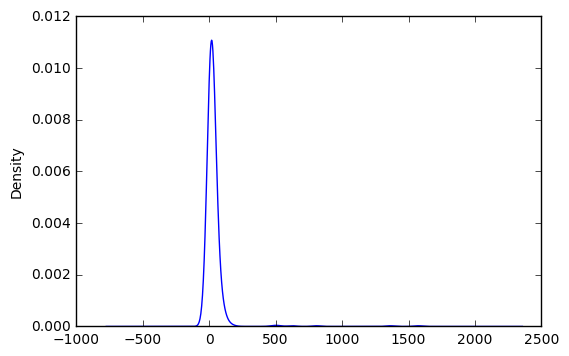

In [17]:
#popularTweets[popularTweets > 1].head(500).plot(kind='bar', xlim=[0, 500], alpha=0.5)
popularTweets[popularTweets > 1].head(500).plot(kind='kde', x=[1,])

In [30]:
mostDiverseTweets = extracted[['userID', 'hash', 'text']].groupby('hash')\
    .agg({'userID': pd.Series.nunique})\
    .sort_values(by='userID', ascending=False)
mostDiverseTweets.columns = ['uniq_users']

# FILTER out singletons
print ('Total number of hashs: {}'.format(mostDiverseTweets.size))
print ('# hashes that were only seen once: {}'.format(mostDiverseTweets[mostDiverseTweets['uniq_users'] == 1].size))

mostDiverseTweets = mostDiverseTweets[mostDiverseTweets['uniq_users'] > 1]   
print ('# hashes that have duplicate users: {}'.format(mostDiverseTweets.size))

mostDiverseTweets.head()

Total number of hashs: 50540
# hashes that were only seen once: 48217
# hashes that have duplicate users: 2323


,uniq_users
hash,
-2964838977105228756,50
8100076757054270788,50
-4993197743230146561,48
5748713145738005256,47
7719283613370225873,19


In [40]:
# users
mostProlificUsers = extracted['screenName'].value_counts()
mostProlificUsers.columns = ['num_tweets']

print ("Number of users: {}".format(mostProlificUsers.size))
print ("Number of users who tweeted < 10: {}".format(mostProlificUsers[mostProlificUsers < 11].size))
print ("Number of users who tweeted > 10: {}".format(mostProlificUsers[mostProlificUsers > 10].size))
print ("The ^^^ [above] were responsible for {} tweets".format(sum(mostProlificUsers[mostProlificUsers > 10])))

print ('\nTop Screen Names')
mostProlificUsers.head(25)

Number of users: 995
Number of users who tweeted < 10: 840
Number of users who tweeted > 10: 155
The ^^^ [above] were responsible for 75250 tweets

Top Screen Names


jCar89000          16989
dtrumptvfan         8337
HydroElections      7697
TheNewsClub_US      4851
Scrufey21           3007
Cary88888888        2692
tweetpoliticsUS     2257
HillaryTapes        1835
jamesnews242        1698
GregJeffery888      1565
CyberAnonymous      1551
PoliticallyGQ       1360
WDYL2016            1112
berserk_news         969
TrussElise           883
DonaldTrumpshow      851
goodbetterbuy        845
openn_world          838
TeamTrumpAZ          829
TBackers             827
klansmen4trump       823
godwin_bot           801
MiriamRoseMc         791
Trump4Hope           704
azblonde2015         657
Name: screenName, dtype: int64

In [20]:
mostProlificUsers.size

995

In [37]:
tweets = extracted[extracted['retweet'] == 0]
retweets = extracted[extracted['retweet'] == 1]

In [39]:
totalObserved = extracted.size
tweetsObserved = tweets.size
retweetsObserved = retweets.size

print ('number of statuses observed: {}\nnumber of tweets: {}\nnumber of retweets: {}'\
       .format(totalObserved, tweetsObserved, retweetsObserved))

number of statuses observed: 771130
number of tweets: 492660
number of retweets: 278470


In [ ]:
# use the value counts to get the hash
hashes['token_str'].value_counts().head(100)

In [ ]:
# time delta function
def tDelta(times):
    delt = max(times) - min()

In [61]:
agg = {
    'userID': {
        'uniq_users': pd.Series.nunique,
        'users': pd.Series.tolist
    }, 'timestamp': {
        'first_day': 'min',
        'last_day': 'max',
        # Calculate time delta # # ).days if (max(x)-min(x).hours > 24) else (max(x)-min(x)).hours
        'time_delta': lambda x: max(x)-min(x)
    }, 'hash': 'count'
}

aggregated = extracted.groupby(['token_str']).agg(agg)
aggregated.columns = ['first_day', 'time_delta', 'last_day', 'uniq_users', 'users', 'count']
aggregated.head()

,first_day,time_delta,last_day,uniq_users,users,count
token_str,,,,,,
"!!, John, Pilger, Why, Hillary, Clinton, Is, More, Dangerous, Than, Donald, Trump, #uspoli, #cdnpoli, #newyork, #california, #ohio, ht, …",2016-04-12 22:22:05.879,0 days,2016-04-12 22:22:05.879,1,[3532804813],1
"!, #BAAAAM, Donald, #Trump, Says, Concealed, Carry, Permit, Holders, ‘, Have, an, Obligation, to, Carry, ’, #greta, #Trump2016, #TCOT, ht, …",2015-11-19 13:40:04.912,0 days,2015-11-19 13:40:04.912,1,[3532804813],1
"!, **, Hiss, **, John, Legend, Fires, Shots, At, Donald, Trump, Read, Here",2016-03-26 14:17:06.783,0 days,2016-03-26 14:17:06.783,1,[3532804813],1
"!, ALERT, Romney/Bush, Conspire, to, Murder, #Trump2016, within, two, weeks, !, 3-4-16, &, …",2016-03-08 18:35:45.569,0 days,2016-03-08 18:35:45.569,1,[490179072],1
"!, List, of, people, who, were, pardoned, by, Bill, Clinton, that, committed, actual, crimes, who, then, donated, to, Hillary-RT, !, http, …",2016-05-15 02:54:21.160,0 days,2016-05-15 02:54:21.160,1,[490179072],1


In [56]:
aggregated[['time_delta', 'uniq_users', 'count']].sort_values(['count', 'uniq_users'], ascending=False).head(100).style.bar(subset=['count'], color='#d65f5f')

In [37]:
test = max(aggregated['last_day']) - min(aggregated['first_day'])
print (test)

630 days 01:45:55.941000


In [46]:
print (test.total_seconds() / 60) # minutes
print (test.total_seconds() / 3600) # hours
print (test.total_seconds() // 86400) # days 

907305.93235
15121.7655392
630.0


/home/user/.anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/user/.anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/user/.anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in multiply
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/user/.anaconda3/envs/py27/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/user/.anaconda3/envs/py27/lib/python2.7/

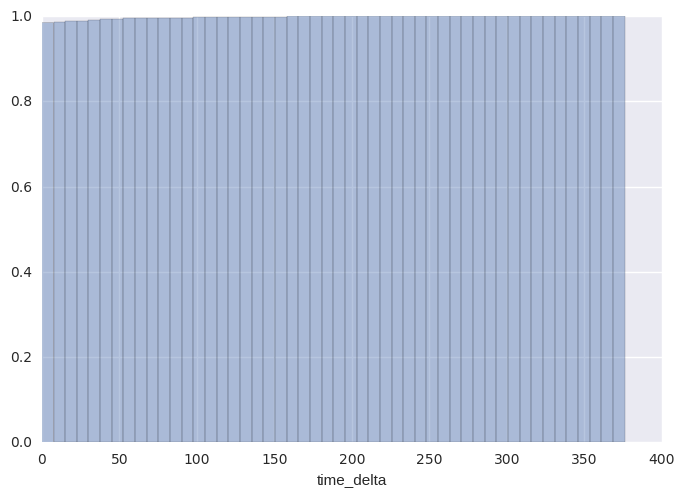

In [107]:
# histogram time deltas
sns.distplot(aggregated.time_delta.apply(lambda x: x.days),
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

KeyError: "[u'total_bill'] not in index"

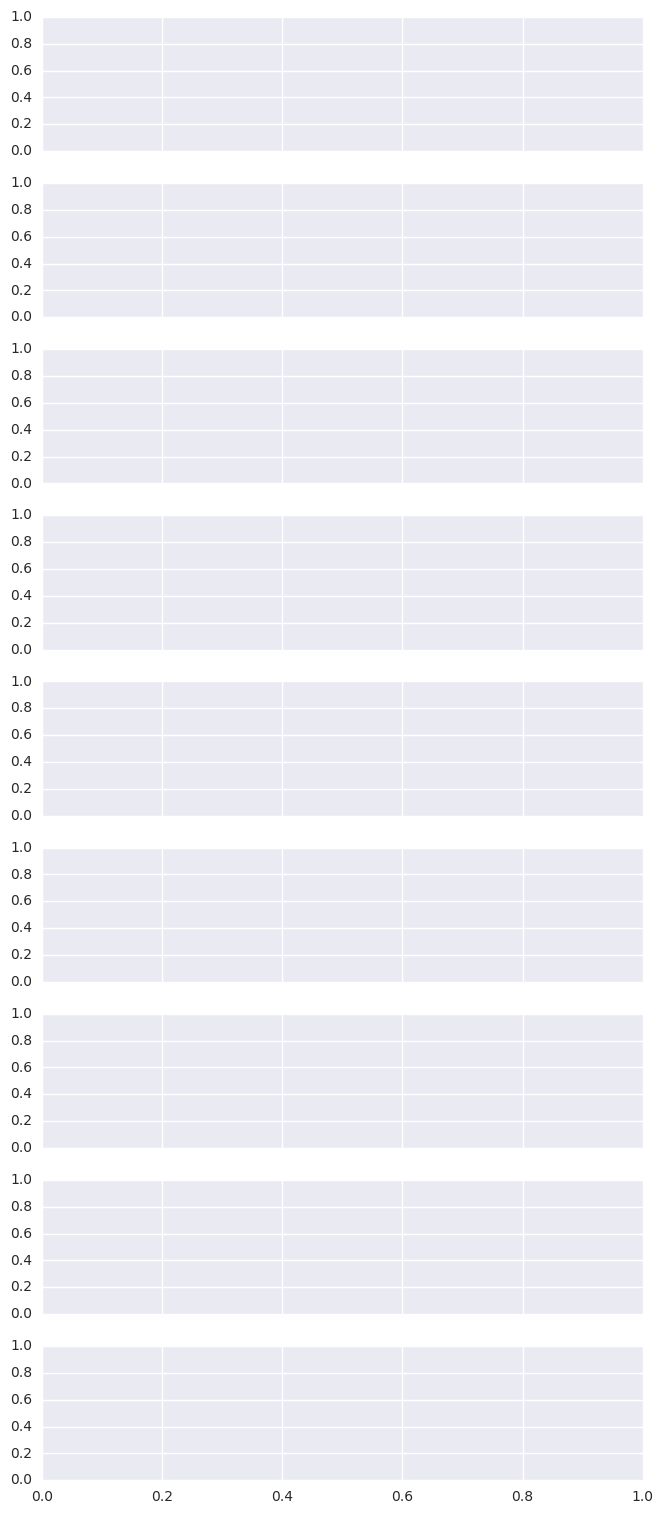

In [114]:
ordered_tweets = aggregated.index
g = sns.FacetGrid(extracted[extracted['token_str'].isin(ordered_tweets[:9].tolist())], \
row="token_str", row_order=ordered_tweets[:9],size=1.7, aspect=4)
g.map(sns.distplot, "token_str", hist=False, rug=True);

In [79]:
# formatting for the datetime display
def timeDeltaDisplay(td):
    if (td.total_seconds() // 86400) < 1:
        return ('{} hours'.format((td.total_seconds() // 3600)))
    else:
        return ('{} days'.format(td.days))

In [80]:
aggregated[['time_delta', 'uniq_users', 'count']]\
    .sort_values('time_delta', ascending=False)\
    .head(25).style.format(timeDeltaDisplay, subset=['time_delta'])\
    .bar(subset=['count', 'total_favorites', 'total_retweets', 'time_delta', 'uniq_users'], color='#d65f5f')